# Image --> Matrix
Given Image Address in Share Repository, Generate Cell Geometry as Matrices. \
Split into binary matrix and RI matrix, processes into RI matrix with only data for cell geometry.

In [41]:
# Import libraries:
import numpy as np
from PIL import Image 
import tiffile as tf
import scipy as sp
import os
import matplotlib.pyplot as plt

# Filter
from scipy.ndimage import median_filter
from scipy.ndimage import gaussian_filter
from skimage.filters import threshold_otsu

## Set-up I/O Path Allocations 
Declare input data path and access tiff or tif. \
The path variable can be changed to output different datas' geometry arrays.

In [30]:
# Path Variables:
repo_path = "/Users/caozehuang/Documents/GitHub/Photon-Transport-Simulation/"     # Replace with repository path
export_address = "data/extracted_ri/"
access_address = "data/processed/"         

# Helpers:
def output_address(subfolder="data/", repository=repo_path):
    out_path = f"{repository}{subfolder}"
    return out_path

def modified_output_address(file_name):
    name_part = file_name.split(".")[0]
    new_name = f"{name_part}_extracted.mat"
    return new_name

In [31]:
# Accessing the file:
file_name = "test.tif"     # Replace with actual file name
access_path = f"{repo_path}{access_address}{file_name}"
print("Accessing: " + access_path)

Accessing: /Users/caozehuang/Documents/GitHub/Photon-Transport-Simulation/data/processed/test.tif


Here, we load and generate Numpy arrays to store our pixel matrices.
1. Raw Matrix(from fiji)
2. RI Matrix(normalized to standard notation)

In [32]:
# Load raw file:
if(file_name.split(".")[-1] == "tiff" or file_name.split(".")[-1] == "tif"):
    raw = tf.imread(access_path)
    print(f"TIFF loaded successfully!")
elif(file_name.split(".")[-1] == "jpeg" or file_name.split(".")[-1] == "jpg" or file_name.split(".")[-1] == "png"):
    raw = Image.open(access_path)
    print(f"Image loaded successfully!")
else:
    raise ValueError("Unsupported file format. Please use TIFF, JPEG, or PNG.")

TIFF loaded successfully!


Raw file information:
Shape: (212, 376)
Data type: uint16


Refractive Index (RI) matrix information:
Shape: (212, 376)
Data type: float64
Min value: 1.3244, Max value: 1.4041


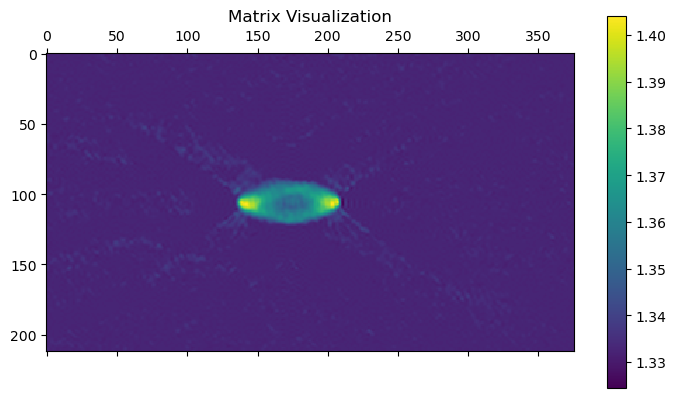

In [33]:
# Convert to numpy array (already a numpy matrix)
try:
    raw_mat = np.array(raw)
except Exception as e:
    print(f"Error converting image to numpy array: {e}")
    raise

# Print raw file information:
print("Raw file information:")
print(f"Shape: {raw_mat.shape}")
print(f"Data type: {raw_mat.dtype}")
print("\n")

# Fix RI values of raw Fiji Output to be in the range of 1.0 to 2.0:
ri_mat = raw_mat / 10000
print("Refractive Index (RI) matrix information:")
print(f"Shape: {ri_mat.shape}")
print(f"Data type: {ri_mat.dtype}")
print(f"Min value: {ri_mat.min()}, Max value: {ri_mat.max()}")

# Plot matrix out to verify
plt.matshow(ri_mat) 
plt.colorbar() # Creates a colorbar for the plot
plt.title("Matrix Visualization")
plt.show() 

# Filtering - Prior to Mask Extraction
1. Fourier Low-pass to remove speckle noise
2. Min filter as extra step

In [49]:
# Fast Fourier Filtering Helper
def fourier_lowpass(ri, sigma=40):  # sigma - width of Gaussian in frequency space
    F = np.fft.fft2(ri)             # Fast Fourier
    F_shift = np.fft.fftshift(F)    # Find Center

    rows, cols = ri.shape
    crow, ccol = rows // 2, cols // 2

    #Create Frequency Axis and Grids
    u = np.arange(rows) - crow 
    v = np.arange(cols) - ccol
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt(U**2 + V**2)    # Radial distance

    # Gaussian Filter
    H = np.exp(-(D**2) / (2 * sigma**2))    

    # Apply filter
    F_filtered = F_shift * H
    F_ishift = np.fft.ifftshift(F_filtered) # Shift back
    ri_filtered = np.fft.ifft2(F_ishift)    # Reverse FFT

    return np.real(ri_filtered)

# Evaluate Fourier Helper 
def evaluate_filtering(ri, ri_filtered):
    F_orig = np.fft.fftshift(np.fft.fft2(ri))
    F_filt = np.fft.fftshift(np.fft.fft2(ri_filtered))

    E_orig = np.sum(np.abs(F_orig)**2)
    E_filt = np.sum(np.abs(F_filt)**2)

    diff = ri - ri_filtered

    print("Energy loss:", (E_orig - E_filt)/E_orig)
    print("Mean abs change:", np.mean(np.abs(diff)))
    print("Max abs change:", np.max(np.abs(diff)))
    print("Peak RI before:", ri.max())
    print("Peak RI after:", ri_filtered.max())


Apply Fourier Filtering
Apply Median Filter
Background Suppression


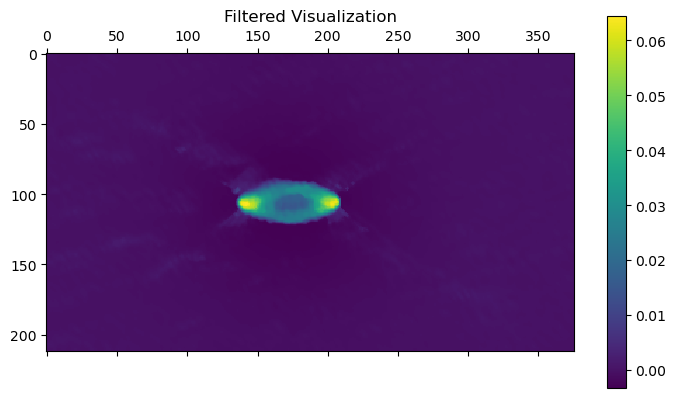

Energy loss: 0.9999880793948515
Mean abs change: 1.333421512444801
Max abs change: 1.3426552282697983
Peak RI before: 1.4041
Peak RI after: 0.06445528263291966


In [50]:
# Fourier Filter
print("Apply Fourier Filtering")
sigma = ri_mat.shape[0] // 8
fourier_mat = fourier_lowpass(ri_mat, sigma) # Lower sigma = more filtering

# Median Filter
print("Apply Median Filter")
ri_med = median_filter(fourier_mat, size=3) # Increase size for greater strength

# Background Suppression - Gaussian Filter
print("Background Suppression")
background = gaussian_filter(ri_smooth, sigma=50)
ri_flat = ri_smooth - background

# Plot
plt.matshow(ri_flat) 
plt.colorbar() # Creates a colorbar for the plot
plt.title("Filtered Visualization")
plt.show() 

# Evaluate filter:
evaluate_filtering(ri_mat, ri_flat)

# Mask Extraction and Processing
1. Move to process the RI tiff file, return binary mask of the RI matrix. 
2. Overlay binary mask onto the RI matrix to retrieve only the RI of the cell body(assume it has been properly filtered). 
3. Return the matrix that only contain the cell body's RI


Binary matrix created with threshold 0.014298602633576686.
Shape: (212, 376)
Unique values in binary matrix: [0 1]


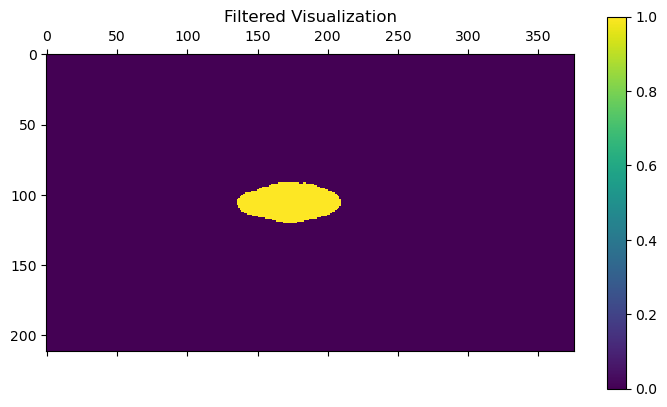

In [45]:
# Apply RI Threshold to mask the image:
ri_threshold = threshold_otsu(ri_flat)  

# Create binary matrix based on RI threshold
binary_mat = np.where(ri_flat >= ri_threshold, 1, 0)
print(f"Binary matrix created with threshold {ri_threshold}.")
print(f"Shape: {binary_mat.shape}")
print(f"Unique values in binary matrix: {np.unique(binary_mat)}")

plt.matshow(binary_mat) 
plt.colorbar() # Creates a colorbar for the plot
plt.title("Filtered Visualization")
plt.show() 

Masked RI matrix created by overlaying binary mask onto RI matrix.

Shape: (212, 376)
Data type: float64
Max value: 1.4041


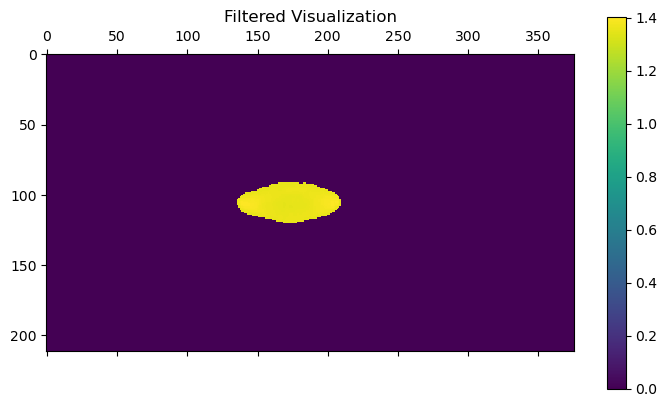

In [48]:
# Makes Matrices are dimensionally compatible
if ri_mat.shape != binary_mat.shape:
    raise ValueError("RI matrix and binary matrix have different shapes. Please check the input data.")

# Apply binary mask to RI matrix
masked_ri_mat = binary_mat * ri_mat

# Print masked RI matrix information:
print("Masked RI matrix created by overlaying binary mask onto RI matrix.\n")
print(f"Shape: {masked_ri_mat.shape}")
print(f"Data type: {masked_ri_mat.dtype}")
print(f"Max value: {masked_ri_mat.max()}")

# Show Matrix
plt.matshow(masked_ri_mat) 
plt.colorbar() # Creates a colorbar for the plot
plt.title("Filtered Visualization")
plt.show() 

# Saving

In [51]:
# Save the extracted geometry as a .mat file:
# Export address and name:
output_path = output_address(export_address, repo_path)
output_name = modified_output_address(file_name=file_name)

# Save
try:
    sp.io.savemat(f"{output_path}{output_name}", {"masked_ri": masked_ri_mat})
    print(f"Extracted RI matrix saved successfully at {output_path}{output_name}!")
except Exception as e:
    print(f"Error saving extracted RI matrix: {e}")
    raise


Extracted RI matrix saved successfully at /Users/caozehuang/Documents/GitHub/Photon-Transport-Simulation/data/extracted_ri/test_extracted.mat!
